In [1]:
# Import own modules
# SelfSupervised
import modules.selfsupervised.simclr_model as sm 
import modules.selfsupervised.simclr_train as smtr
# Evaluation
import modules.evaluation.lin_eval_testmoduls as let
# Utils
import modules.utils.transformations as t 
import modules.utils.loss_functions as lf
import modules.utils.lars as lars
# Settings
import modules.utils.get_data as get 
# Reporting 
import modules.utils.reporting as report 
# Saving Model
import modules.utils.save_model as savem
# Get Model
import modules.utils.get_model as gm 
# Import extern modules
import argparse
import torchvision
import torch 
import torch.nn as nn
from torch.nn.parallel import DataParallel
import math 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
import glob

from torchvision import transforms
from os import path
import random

import modules.utils.dataloader as satelliteLoader

import torch 
import numpy as np 
from tqdm import tqdm
import math
import torch.nn as nn
from statistics import mean 

from modules.utils.utils import img_to_array

In [2]:
# Create an Argparser
parser = argparse.ArgumentParser(description='Train simCLRv1 on CIFAR-10')
# Model-Architecture
parser.add_argument('-a', '--arch', default='resnet18')
# lr: 0.06 for batch 512 (or 0.03 for batch 256) 0.12 for 1024?
parser.add_argument('--lr', '--learning-rate', default=1e-3, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--epochs', default=20, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--schedule', default=[1020, 1060], nargs='*', type=int, help='learning rate schedule (when to drop lr by 10x); does not take effect if --cos is on')
parser.add_argument('--cos', default="False", type=str, help='use cosine lr schedule')
parser.add_argument('--squared', default="False", type=str, help='use square lr schedule')
parser.add_argument('--batch-size', default=768, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--wd', default=1e-6, type=float, metavar='W', help='weight decay')
parser.add_argument('--dataset', default="IMAGENET", type=str, metavar='W', help='dataset')
parser.add_argument('--dataset-dir', default="data/imagenet128", type=str, metavar='W', help='dataset directory')
parser.add_argument('--optimizer', default="adam", type=str, metavar='W', help='Adam, SGD, Lars')
# SIMCLR specific configs:
parser.add_argument('--dim', default=128, type=int, help='feature dimension')
parser.add_argument('--t', default=0.1, type=float, help='softmax temperature')
parser.add_argument('--numberviews', default=2, type=int, help='Number of Views created for Avg.Loss')
# Training/Test Settings
parser.add_argument('--model-dir', default="", type=str, metavar='W', help='if test true give model dir!')
parser.add_argument('--model-name', default="", type=str, metavar='W', help='if test true give model dir!')
# Linear Evaluation
parser.add_argument('--epochs-lineval', default=100, type=int, metavar='N', help='number of total epochs to run in linEval')
# Labels
parser.add_argument('--labels', default="full", type=str, metavar='N', help='1%, 10% or full labelled data sets are supported')
# Multiple GPUs
parser.add_argument('--dataparallel', default="True", type=str, metavar='W', help='multiple gpus true or false')
# Reload
parser.add_argument('--reload', default="False", type=str, metavar='W', help='reload true or false')
# Verbose
parser.add_argument('--verbose', default="True", type=str, help='True if you want to evaluate your representations after each epoch (obviously SLOWER!)')

# Set up args
args = parser.parse_args("")

In [3]:
# Convert 
args.dataparallel = True if str.lower(args.dataparallel) == "true" else False
args.reload = True if str.lower(args.reload) == 'true' else False
args.verbose = True if str.lower(args.verbose) == 'true' else False
args.cos = True if str.lower(args.cos) == 'true' else False
args.squared = True if str.lower(args.squared) == 'true' else False
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.num_gpus = torch.cuda.device_count()

In [4]:
def percentile(arr, low=1, high=99, mode=None, no_data_vec=None, estimate=True, copy=False):
    """Balances colors either channelwise or for the whole image.

    out = (arr - p(low))/(p(high)-p(low))
    where p is the percentile value.

    p(99) is the value, for which 99% of pixels are darker than this value.

    Out values are clipped to (0,1).

    WARNING: Layerwise modifies in-place!

    Args:
        arr (ndarray): Input array.
        low (int or float): Low percentile value, default: 1
        high (int or float): High percentile value, default: 99
        mode (str): 'layerwise' will treat each layer individually
        no_data_vec (iterable): Regions equaling this color will be omitted in color balancing.
        estimate (bool): If True, percentile value will be estimated using 1/16th of the data.
        copy (bool): If True, acts on a copy of the data. Otherwise the input array is modified!

    Returns: Color balanced array.
    """

    inc = 4 if estimate else 1
    shape = arr.shape
    if no_data_vec is not None:
        assert shape[-1]==len(no_data_vec), "Length of no_data_vec must match number of channels."
        data_mask = np.all(arr.reshape( (-1,shape[-1]) ) != no_data_vec, axis=1).reshape(shape[:2])[::inc, ::inc]

    if mode=='layerwise' and arr.ndim==3:
        img = arr if not copy else np.copy(arr)
        for i in range(arr.shape[-1]):
            tmp1 = arr[::inc,::inc,i]
            tmp2 = tmp1[data_mask] if no_data_vec is not None else tmp1
            minp = np.percentile(tmp2, low)
            maxp = np.percentile(tmp2, high) - minp + 1E-4
            img[:,:,i] = np.clip((arr[:,:,i] - minp) / maxp, 0, 1)
        return img

    else:
        tmp1 = arr[::inc,::inc]
        tmp2 = tmp1[data_mask] if no_data_vec is not None else tmp1
        minp = np.percentile(tmp2, low)
        maxp = np.percentile(tmp2, high) - minp + 1E-4
        return np.clip((arr - minp) / maxp, 0, 1)

In [5]:
def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        ####################
        ## YOUR CODE HERE ##
        ####################
        extra_point=plt.plot(extra_pt[0],extra_pt[1],'k.',label=extra_pt_label, markersize=16)
        if extra_pt_label:
            legend.append(extra_pt_label)

        # END OF YOUR CODE #
        
    plt.vlines(20, 0, 1)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

In [6]:
import torch
from torch.nn import Module
from torch.nn import Sequential
from torch.nn import Conv2d, Dropout2d, MaxPool2d, ReLU, UpsamplingNearest2d


# Based on https://github.com/divamgupta/image-segmentation-keras/blob/master/keras_segmentation/models/unet.py#L19
class UNetMini(Module):

    def __init__(self, num_classes):
        super(UNetMini, self).__init__()

        # Use padding 1 to mimic `padding='same'` in keras,
        # use this visualization tool https://ezyang.github.io/convolution-visualizer/index.html
        self.block1 = Sequential(
            Conv2d(7, 32, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(32, 32, kernel_size=3, padding=1),
            ReLU(),
        )
        self.pool1 = MaxPool2d((2, 2))

        self.block2 = Sequential(
            Conv2d(32, 64, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU(),
        )
        self.pool2 = MaxPool2d((2, 2))

        self.block3 = Sequential(
            Conv2d(64, 128, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(128, 128, kernel_size=3, padding=1),
            ReLU()
        )

        self.up1 = UpsamplingNearest2d(scale_factor=2)
        self.block4 = Sequential(
            Conv2d(192, 64, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU()
        )

        self.up2 = UpsamplingNearest2d(scale_factor=2)
        self.block5 = Sequential(
            Conv2d(96, 32, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(32, 32, kernel_size=3, padding=1),
            ReLU()
        )

        self.conv2d = Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        out1 = self.block1(x)
        out_pool1 = self.pool1(out1)

        out2 = self.block2(out_pool1)
        out_pool2 = self.pool1(out2)

        out3 = self.block3(out_pool2)

        out_up1 = self.up1(out3)
        # return out_up1
        out4 = torch.cat((out_up1, out2), dim=1)
        out4 = self.block4(out4)

        out_up2 = self.up2(out4)
        out5 = torch.cat((out_up2, out1), dim=1)
        out5 = self.block5(out5)

        out = self.conv2d(out5)

        return out

In [7]:
class SatelliteDatasetLabelled(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        super(SatelliteDatasetLabelled).__init__()

        
        self.trainset = []
        self.valset = []
        self.testset = []
        self.transform = transform
        self.dataset = "train"
        threshold = 0.17
        
        for file in glob.glob("../../../data/bangalore/training_data/treecover_segmentation/masks_north/*"):

            filenum = file[78::].split(".")[0]

            src = "../../../data/bangalore/training_data/treecover_segmentation/tiles_north/tile_"+filenum+".tif"
            testsrc =  "../../../data/bangalore/training_data/treecover_segmentation/tiles_north/tiles_on_strip_0/tile_"+filenum+".tif"

            imgArr = img_to_array(file)
        
            if path.exists(testsrc):
                im = torch.from_numpy(img_to_array(testsrc, dim_ordering="CHW")).float()
                imgArr = torch.from_numpy(img_to_array(file, dim_ordering="CHW")).float()
                self.testset.append((im, imgArr))     
            else:
                im = torch.from_numpy(img_to_array(src, dim_ordering="CHW")).float()
                imgArr = torch.from_numpy(img_to_array(file, dim_ordering="CHW")).float()
                self.trainset.append((im, imgArr))

        i = 0
        while i < 90:
            randint = random.randint(0, len(self.trainset)-1)
            im = self.trainset[randint][0]
            mask = self.trainset[randint][1]
            self.valset.append((im, mask))
            self.trainset.pop(randint)
            i += 1 

    def __getitem__(self, idx): 
             
        
        if self.dataset == "train":
            data = self.trainset[idx]
        elif self.dataset == "val":
            data = self.valset[idx]
        else:
            data = self.testset[idx]
            
        if self.transform:
            aug = self.transform(data[0])
            aug2 = self.transform(data[1])
            data = (aug, aug2)
            
        return data

    def __len__(self):
        if self.dataset == "train":
            return len(self.trainset)
        elif self.dataset == "val":
            return len(self.valset)
        else:
            return len(self.testset)

In [24]:
def train_lr(loader, model, criterion, optimizer, epoch, maxepochs, args):
    """
    Input:
        loader: Pytorch dataloader containing the data
        model: The model you want to train
        criterion: Loss function
        optimizer: The optimizer used during training
        epoch: Type int - the epoch the model is currently trained
        maxepochs: The maximal epochs you want to train
        args: Argument list

        Training the evaluation model
    """
    model.train()
    epoch_loss = []
    epoch_acc = []
    train_bar =  tqdm(loader)

    for x, y in train_bar:
        optimizer.zero_grad()
        masks = y.reshape(y.shape[0], y.shape[2], y.shape[3]).long()
        x = x.to(args.device)
        masks = masks.to(args.device)

        output = model(x)
        loss = criterion(output, masks)
        predicted = output.argmax(1)
        #mean_acc = (masks == predicted) / ((224*224)*masks.shape[0])
        mean_acc = torch.sum(1 - torch.sum(torch.abs(masks - predicted), dim=(1,2)) / (224*224)) / masks.shape[0]

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(mean_acc.item())
        
        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}, Acc_Train: {:.4f}'.format(epoch, maxepochs, optimizer.param_groups[0]['lr'], 
                                                                                                        mean(epoch_loss), mean(epoch_acc)))

    return mean(epoch_loss), mean(epoch_acc)

In [25]:
def test_lr(loader, model, criterion, epoch, maxepochs, args):
    """
    Input:
        loader: Pytorch dataloader containing the data
        model: The model you want to train
        criterion: Loss function
        optimizer: The optimizer used during training
        epoch: Type int - the epoch the model is currently trained
        maxepochs: The maximal epochs you want to train
        args: Argument list

        Testing/Validating the evaluation model
    """
    model.eval()
    epoch_loss = []
    epoch_acc = []
    test_bar = tqdm(loader)
    with torch.no_grad():
        for x, y in test_bar:
            masks = y.reshape(y.shape[0], y.shape[2], y.shape[3]).long()
            x = x.to(args.device)
            masks = masks.to(args.device)
            
            output = model(x)
            loss = criterion(output, masks)
            predicted = output.argmax(1)
            
            mean_acc = torch.sum(1 - torch.sum(torch.abs(masks - predicted), dim=(1,2)) / (224*224)) / masks.shape[0]

            epoch_loss.append(loss.item())
            epoch_acc.append(mean_acc.item())
            
            test_bar.set_description('Val Epoch: [{}/{}], Loss: {:.4f}, Acc_Val: {:.4f}'.format(epoch, maxepochs, mean(epoch_loss), mean(epoch_acc)))

    return mean(epoch_loss), mean(epoch_acc)

In [8]:
dataset_train = satelliteLoader.SatelliteDataset(folder = "../../../data/bangalore/raster/strips_north_2016/", transform = t.TransformsSimCLR_SAT(imgsize=224), iterate_over_all=True)
dataset = SatelliteDatasetLabelled(transform=t.TransformsSimCLR_SAT(imgsize=224).test_transform_SAT_SUP)
dataset_train_nonaug = dataset 
dataset.dataset, dataset.transform = "val", t.TransformsSimCLR_SAT(imgsize=224).test_transform_SAT_SUP
dataset_validation = dataset 
num_workers = 0

In [39]:
args.batch_size = 5
args.epochs = 20

In [40]:
trainloader, trainloader_nonaug, valloader = get.dataloaders_trainingSimclr(dataset_train, dataset_train_nonaug, dataset_validation, num_workers, args)

In [49]:
# To Device
model = UNetMini(2).to(args.device)

# Set Optimizer
optimizer = get.optimizer_training(model, args)

criterion = torch.nn.CrossEntropyLoss()
epoch_start = 1

In [50]:
train_losses =[]
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epoch_start, args.epochs + 1):
    train_loss, train_acc = train_lr(trainloader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
            
    #train_loss, train_acc, lr = st.train(model, train_loader, optimizer, criterion, epoch, args)
    val_loss, val_acc = test_lr(valloader, model, criterion, epoch, args.epochs, args)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

Train Epoch: [1/20], lr: 0.001000, Loss: 1.4445, Acc_Train: 0.6634: 100%|██████████| 18/18 [00:01<00:00, 17.32it/s]
Val Epoch: [1/20], Loss: 0.4330, Acc_Val: 0.7725: 100%|██████████| 18/18 [00:00<00:00, 49.29it/s]
Train Epoch: [2/20], lr: 0.001000, Loss: 0.4421, Acc_Train: 0.7721: 100%|██████████| 18/18 [00:00<00:00, 18.26it/s]
Val Epoch: [2/20], Loss: 0.3736, Acc_Val: 0.7921: 100%|██████████| 18/18 [00:00<00:00, 49.17it/s]
Train Epoch: [3/20], lr: 0.001000, Loss: 0.3865, Acc_Train: 0.7830: 100%|██████████| 18/18 [00:00<00:00, 18.34it/s]
Val Epoch: [3/20], Loss: 0.3630, Acc_Val: 0.8188: 100%|██████████| 18/18 [00:00<00:00, 48.32it/s]
Train Epoch: [4/20], lr: 0.001000, Loss: 0.3658, Acc_Train: 0.8189: 100%|██████████| 18/18 [00:00<00:00, 18.20it/s]
Val Epoch: [4/20], Loss: 0.3257, Acc_Val: 0.8399: 100%|██████████| 18/18 [00:00<00:00, 48.16it/s]
Train Epoch: [5/20], lr: 0.001000, Loss: 0.3506, Acc_Train: 0.8280: 100%|██████████| 18/18 [00:00<00:00, 18.10it/s]
Val Epoch: [5/20], Loss: 0.3

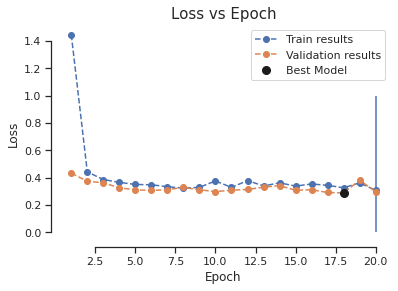

Best Loss-Value for Validation: 0.2883121466471089 at Epoch 18


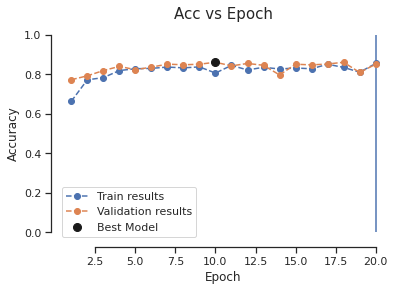

Best Accuracy for Validation: 0.8609308633539412 at Epoch 10


In [51]:
min_value = min(val_losses)
min_index = val_losses.index(min_value)+1

plot("Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=(min_index, min_value), extra_pt_label="Best Model")
print(f"Best Loss-Value for Validation: {min_value} at Epoch {min_index}")

max_value = max(val_accs)
max_index = val_accs.index(max_value)+1
plot("Acc vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=(max_index, max_value), extra_pt_label="Best Model")
print(f"Best Accuracy for Validation: {max_value} at Epoch {max_index}")

In [43]:
for images, masks in trainloader_nonaug: #trainloader_nonaug
    model.eval()
    print(masks.shape)
    masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3]).long().cuda()
    print(masks.shape)
    output = model(images.cuda())
    loss = criterion(output, masks)
    predicted = output.argmax(1)
    print(predicted.shape)
    break

torch.Size([5, 1, 224, 224])
torch.Size([5, 224, 224])
torch.Size([5, 224, 224])


In [44]:
predicted.shape

torch.Size([5, 224, 224])

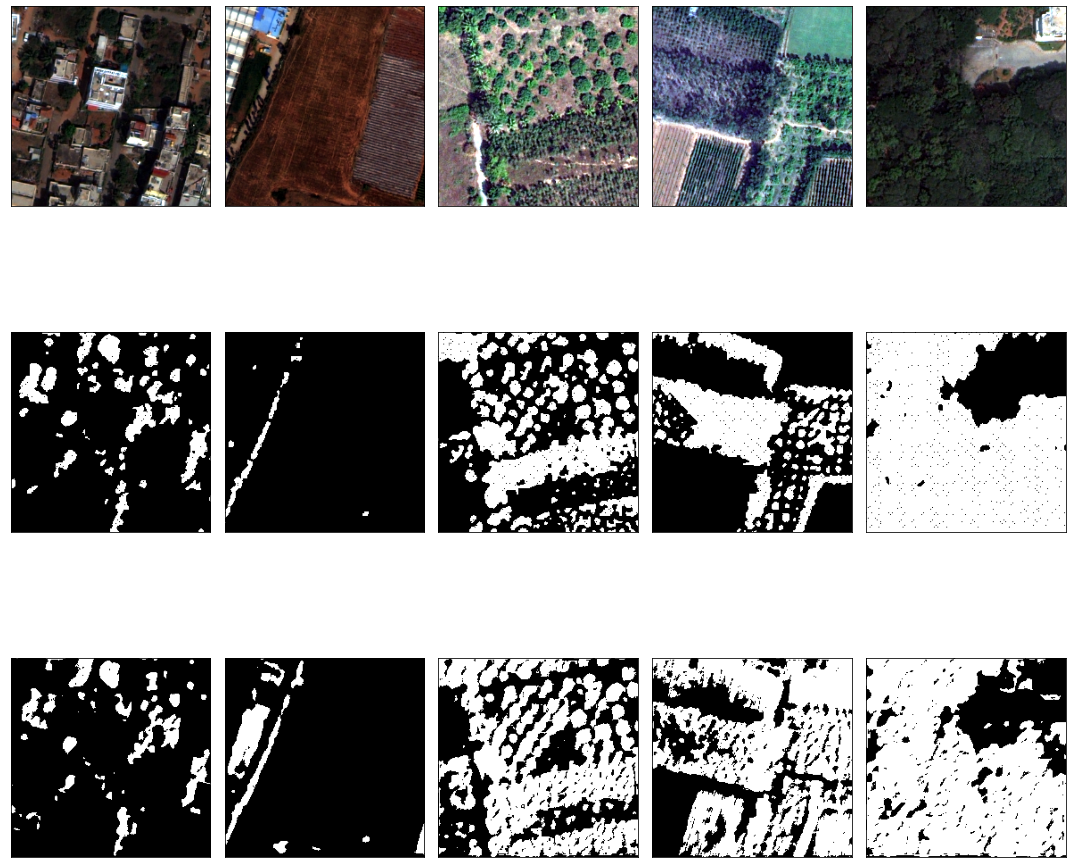

In [45]:
n_images = len(images)
cols = n_images
rows = 3
plt.figure(figsize=(15, 15))
for i in range(n_images*rows):
    if i<n_images:
        img = images[i][(3,1,0),:,:].permute(1,2,0)
        img = percentile(img, mode="layerwise", copy=True)
    elif i<n_images*2:
        img = masks.cpu()[i-n_images][:,:]
    else:
        img = predicted.cpu()[i-n_images*2][:,:]
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [46]:
for images, masks in valloader: #trainloader_nonaug
    model.eval()
    masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3]).long().cuda()
    output = model(images.cuda())
    loss = criterion(output, masks)
    predicted = output.argmax(1)
    break

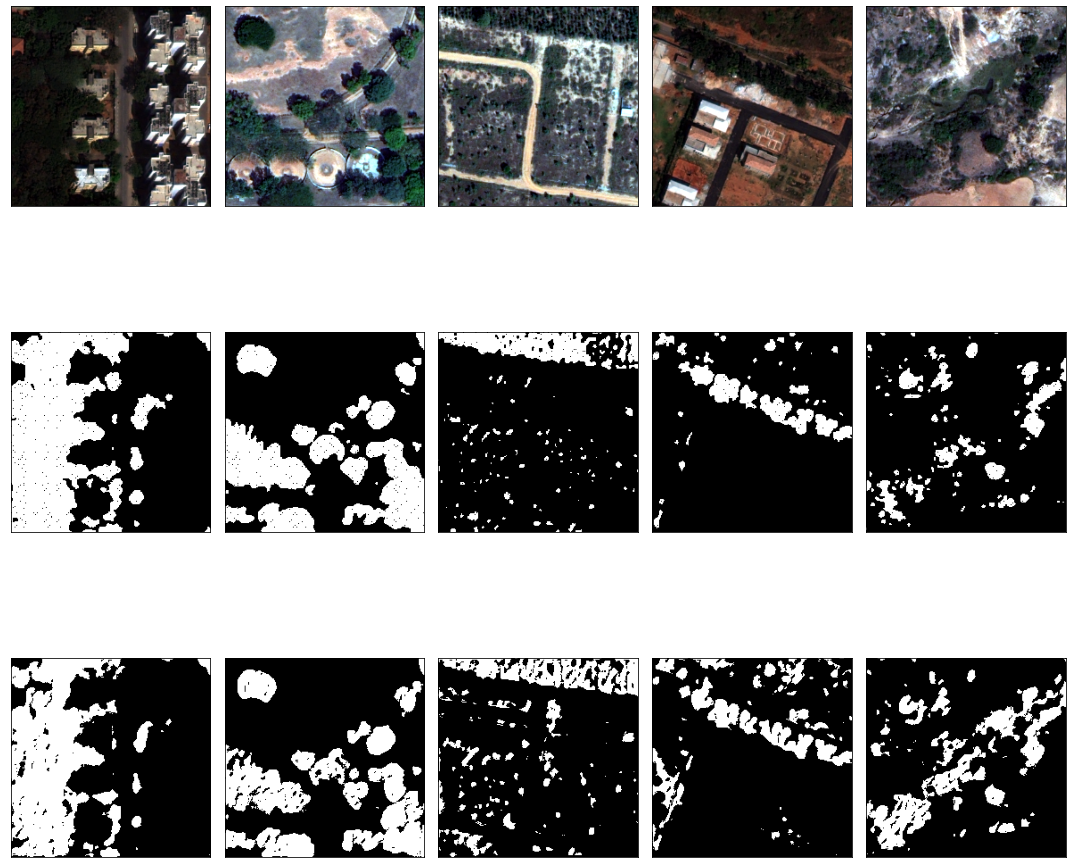

In [47]:
n_images = len(images)
cols = n_images
rows = 3
plt.figure(figsize=(15, 15))
for i in range(n_images*rows):
    if i<n_images:
        img = images[i][(3,1,0),:,:].permute(1,2,0)
        img = percentile(img, mode="layerwise", copy=True)
    elif i<n_images*2:
        img = masks.cpu()[i-n_images][:,:]
    else:
        img = predicted.cpu()[i-n_images*2][:,:]
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()